In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd 
from pathlib import Path
from bioblp.data import COL_EDGE, COL_SOURCE, COL_TARGET

/home/jovyan/.conda/envs/bioblp-env/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [28]:
DATA_DIR = Path("../data")
SHARED_DIR = Path("/home/jovyan/workbench-shared-folder/bioblp/data")

In [4]:
!ls {SHARED_DIR}/models

1baon0eg  iwy9z7m9


## Load benchmark

In [5]:
dpi_benchmark_path = SHARED_DIR.joinpath('data/benchmarks/transductive/dpi_fda.tsv') 

In [6]:
dpi_bm = pd.read_csv(dpi_benchmark_path, sep='\t', names=[COL_SOURCE, COL_EDGE, COL_TARGET])
dpi_bm.head(3)

,src,edg,tgt
0,DB01079,DPI,Q13639
1,DB00114,DPI,P20711
2,DB01158,DPI,P13637



* [DB01079; Tegaserod](https://go.drugbank.com/drugs/DB01079)
Tegaserod is a serotonin-4 (5-HT4) receptor agonist indicated for the treatment of constipation predominant irritable bowel syndrome (IBS-C) specifically in women under the age of 65. There is currently no safety or efficacy data for use of tegaserol in men.

* https://www.uniprot.org/uniprotkb/Q13639/entry

In [7]:
dpi_drugs_unique = list(dpi_bm.src.unique())
dpi_prots_unique = list(dpi_bm.tgt.unique())
print(f'# total dpi instances (TP): {len(dpi_bm)}')
print(f'# Unique Drugs: {len(dpi_drugs_unique)}')
print(f'# Unique Proteins: {len(dpi_prots_unique)}')


# total dpi instances (TP): 18678
# Unique Drugs: 2167
# Unique Proteins: 2573


## Prepare Data for ML

In [8]:
from bioblp.benchmarking.featurize import load_model_and_entity_to_id_maps, ENTITY_TO_ID_MAP, RELATION_TO_ID_MAP

In [20]:
model_dir = SHARED_DIR.joinpath('models/1baon0eg')
model_dir_best = SHARED_DIR.joinpath('models/iwy9z7m9')
kge_artifacts = load_model_and_entity_to_id_maps(model_dir_best)
entity_to_id_map = kge_artifacts.get(ENTITY_TO_ID_MAP)
relation_to_id_map = kge_artifacts.get(RELATION_TO_ID_MAP)


01:05:04 - INFO - bioblp.benchmarking.featurize - Loading trained model from /home/jovyan/workbench-shared-folder/bioblp/models/iwy9z7m9


In [21]:
#relation_to_id_map

### Generate Negative samples

In [22]:
from bioblp.benchmarking.preprocess import prepare_dpi_samples

In [23]:
num_negs_per_pos=10
pos_neg_df = prepare_dpi_samples(dpi_bm, 
                                 entity_to_id_map=entity_to_id_map, 
                                 relation_to_id_map= relation_to_id_map,
                                num_negs_per_pos=num_negs_per_pos)

Reconstructing all label-based triples. This is expensive and rarely needed.


In [24]:
pos_neg_df

,src,edg,tgt,label
0,DB01079,DPI,Q13639,1
1,DB00114,DPI,P20711,1
2,DB01158,DPI,P13637,1
3,DB01069,DPI,P18825,1
4,DB01186,DPI,P08684,1
...,...,...,...,...
205453,DB15690,DPI,P61078,0
205454,DB15690,DPI,P63292,0
205455,DB15690,DPI,MIM:614073,0
205456,DB15690,DPI,O14126,0


In [29]:
#dpi_postprocessed_path = DATA_DIR.joinpath(f"benchmarks/processed/dpi_benchmark_p2n-1-{num_negs_per_pos}.tsv")
dpi_postprocessed_path = SHARED_DIR.joinpath(f"benchmarks/processed/dpi_benchmark_p2n-1-{num_negs_per_pos}.tsv")
pos_neg_df.to_csv(dpi_postprocessed_path, sep='\t')

### Featurize by obtaining joint entity pair encoding

In [26]:
from bioblp.benchmarking.featurize import KGEMFeaturizer, RandomNoiseFeaturizer

In [27]:
random_feat = RandomNoiseFeaturizer(joint_transform_operator="concatenate", dim=128
                                   )
X_r, y_r = random_feat.featurize_entity_pairs(data=pos_neg_df,
                                      lookuptable_outdir="data/benchmarks"
                                         )

01:05:10 - INFO - bioblp.benchmarking.featurize - Mapping entities to KG identifiers
01:05:10 - INFO - bioblp.benchmarking.featurize - Applying transformation function to retrieve joint encoding for entity pair


In [63]:
kgem_featurizer = KGEMFeaturizer(joint_transform_operator="concatenate")
kgem_featurizer.joint_transform_operator

'concatenate'

In [64]:
X, y = kgem_featurizer.featurize_entity_pairs(data=pos_neg_df,
                                              model_data_path= model_dir_best,
                                               )

22:17:37 - INFO - bioblp.benchmarking.featurize - Loading trained model from /home/jovyan/workbench-shared-folder/bioblp/models/iwy9z7m9
22:17:38 - INFO - bioblp.benchmarking.featurize - Mapping entities to KG identifiers
22:17:38 - INFO - bioblp.benchmarking.featurize - Applying transformation function to retrieve joint encoding for entity pair


In [149]:
kgem_featurizer.save(X, y, outdir="hello")

21:51:12 - INFO - bioblp.benchmarking.featurize - Saved featurized instances and correponding labels y to hello


## Train ML model for binary clf

In [22]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

In [44]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.1, 
                                                    random_state=0, shuffle=True)

In [45]:
lr = LogisticRegression(max_iter=300)
lr.fit(x_train, y_train)

LogisticRegression(max_iter=300)

In [66]:
x_train_r, x_test_r, y_train_r, y_test_r = train_test_split(X_r, y_r, test_size=0.1, 
                                                    random_state=0, shuffle=True)

In [67]:
lr_rand = LogisticRegression(max_iter=300)
lr_rand.fit(x_train_r, y_train_r)

LogisticRegression(max_iter=300)

In [48]:
# predictions
y_testpred = lr.predict(x_test)

In [68]:
y_testpred_r = lr_rand.predict(x_test_r)

In [49]:
# score
# Use score method to get accuracy of model
insample_acc= lr.score(x_train, y_train)
test_acc = lr.score(x_test, y_test)
print(f"Insample accuracy: {insample_acc}")
print(f"Test accuracy: {test_acc}")

Insample accuracy: 0.9551786795881284
Test accuracy: 0.953762289496739


In [70]:
# score
# Use score method to get accuracy of model
insample_acc= lr_rand.score(x_train_r, y_train_r)
test_acc = lr_rand.score(x_test_r, y_test_r)
print(f"Insample accuracy: {insample_acc}")
print(f"Test accuracy: {test_acc}")

Insample accuracy: 0.9088972051570476
Test accuracy: 0.9108342256400273


#### confusion matrix

In [50]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics

In [51]:
metrics.classification_report(y_test, y_testpred)

'              precision    recall  f1-score   support\n\n           0       0.97      0.98      0.97     18714\n           1       0.78      0.67      0.72      1832\n\n    accuracy                           0.95     20546\n   macro avg       0.87      0.83      0.85     20546\nweighted avg       0.95      0.95      0.95     20546\n'

In [52]:
print(metrics.classification_report(y_test, y_testpred))

              precision    recall  f1-score   support

           0       0.97      0.98      0.97     18714
           1       0.78      0.67      0.72      1832

    accuracy                           0.95     20546
   macro avg       0.87      0.83      0.85     20546
weighted avg       0.95      0.95      0.95     20546



In [53]:
cm = metrics.confusion_matrix(y_test, y_testpred)
print(cm)

[[18363   351]
 [  599  1233]]


In [54]:
cm_best = metrics.confusion_matrix(y_test, y_testpred)
print(cm_best)

[[18363   351]
 [  599  1233]]


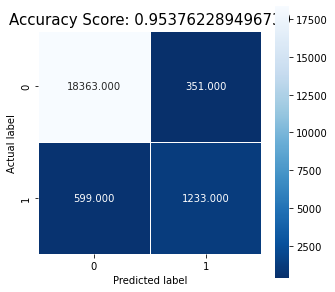

In [55]:
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(test_acc)
plt.title(all_sample_title, size = 15);

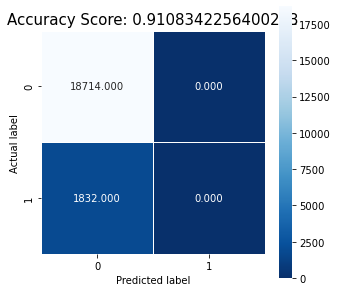

In [71]:
cm_best_r = metrics.confusion_matrix(y_test_r, y_testpred_r)

plt.figure(figsize=(5,5))
sns.heatmap(cm_best_r, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(test_acc)
plt.title(all_sample_title, size = 15);

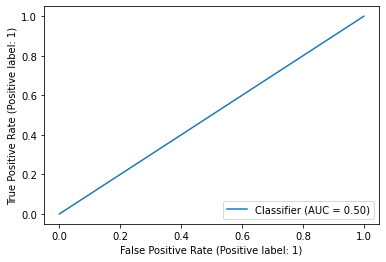

In [72]:
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay
RocCurveDisplay.from_predictions(y_test_r, y_testpred_r)
plt.show()

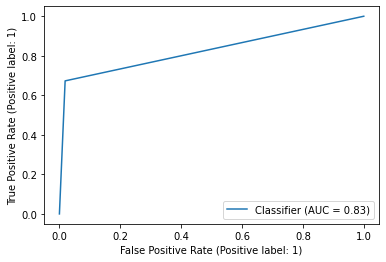

In [57]:
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay
RocCurveDisplay.from_predictions(y_test, y_testpred)
plt.show()

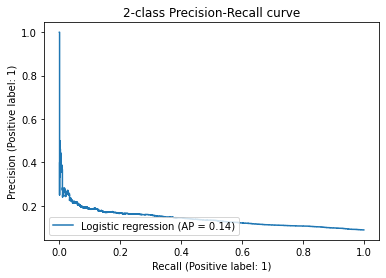

In [74]:
from sklearn.metrics import PrecisionRecallDisplay

display = PrecisionRecallDisplay.from_estimator(
    lr_randand, x_test_r, y_test_r, name="Logistic regression"
)
_ = display.ax_.set_title("2-class Precision-Recall curve")

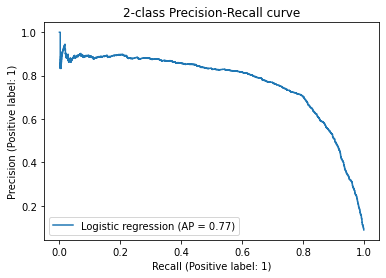

In [59]:
from sklearn.metrics import PrecisionRecallDisplay

display = PrecisionRecallDisplay.from_estimator(
    lr, x_test, y_test, name="Logistic regression"
)
_ = display.ax_.set_title("2-class Precision-Recall curve")